# Blackpink Classification

#### "Blackpink in your area..."

Goal: To accurately classify the 4 members of Blackpink

Dataset outline:
- Scraped images from search engines
- 500 images x 4 members = 2000 raw images
    1. 60-20-20 train-dev-test initial split => 300 train, 100 dev and 100 test images per class
    2. 300 train set images -- IMAGE AUGMENTATION (x6) --> 1800 train set images per class
    3. Total: 1800 train, 100 dev and 100 test images per class (90-5-5 split)
- In total: 2000 images x 4 members = 8000 images

## Load Packages

In [1]:
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras import regularizers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

import keras.backend as K
K.set_image_data_format('channels_last')

#from keras.utils import layer_utils
#from keras.utils.data_utils import get_file

import pydot
import graphviz
from IPython.display import SVG

import h5py

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

Using TensorFlow backend.


In [2]:
# TO DO TRANSFER LEARNING
# Importing MobileNetV2
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential

## Variable Constants

In [3]:
# TITLE OF YOUR H5 FILE
H5_FILE_TITLE = 'Blackpink_Classification'

# CONSTANTS WHICH ACTS AS AN IDENTIFIER FOR EACH CLASS
# USED AS A CAPTION AT THE END OF THE NOTEBOOK
Y0 = "It's Jisoo!"
Y1 = "It's Jennie!"
Y2 = "It's Rose!"
Y3 = "It's Lisa!"
IDENTIFIER = [Y0,Y1,Y2,Y3]
CLASS_COUNT = len(IDENTIFIER)

# OVERALL FILE PATH OF YOUR TRAIN, DEV, TEST SET
DATAPATH_TRAIN = 'train_' + H5_FILE_TITLE
DATAPATH_DEV = 'dev_' + H5_FILE_TITLE
DATAPATH_TEST = 'test_' + H5_FILE_TITLE

## Load Datasets

In [4]:
# Check training set in a h5 file 
a = h5py.File('datasets/'+ DATAPATH_TRAIN +'.h5', "r")
list(a)

['train_list_classes', 'train_set_x', 'train_set_y']

In [5]:
# Check dev set in a h5 file 
b = h5py.File('datasets/'+ DATAPATH_DEV +'.h5', "r")
list(b)

['dev_list_classes', 'dev_set_x', 'dev_set_y']

In [6]:
# Check test set in a h5 file
c = h5py.File('datasets/'+ DATAPATH_TEST +'.h5', "r")
list(c)

['test_list_classes', 'test_set_x', 'test_set_y']

In [7]:
def load_dataset(train_dir, dev_dir, test_dir):
    
    '''
        Args:
            -- train_dir: a directory where train set images reside
            -- dev_dir: a directory where dev set images reside
            -- test_dir: a directory where test set images reside
    '''
    
    train_dataset = h5py.File('datasets/'+ train_dir +'.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
    
    dev_dataset = h5py.File('datasets/'+ dev_dir +'.h5', "r")
    dev_set_x_orig = np.array(dev_dataset["dev_set_x"][:]) # your dev set features
    dev_set_y_orig = np.array(dev_dataset["dev_set_y"][:]) # your dev set labels

    test_dataset = h5py.File('datasets/'+ test_dir +'.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["test_list_classes"][:]) # the list of classes
    
    #train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    #test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, dev_set_x_orig, dev_set_y_orig ,test_set_x_orig, test_set_y_orig, classes

In [8]:
X_train_orig, Y_train_orig, X_dev_orig, Y_dev_orig, X_test_orig, Y_test_orig, classes = load_dataset(DATAPATH_TRAIN,DATAPATH_DEV,DATAPATH_TEST)

In [9]:
X_train_orig.shape

(6792, 128, 128, 3)

In [10]:
Y_train_orig.shape

(1, 6792)

In [11]:
X_dev_orig.shape

(400, 128, 128, 3)

In [12]:
Y_dev_orig.shape

(1, 400)

In [13]:
X_test_orig.shape

(400, 128, 128, 3)

In [14]:
Y_test_orig.shape

(1, 400)

## Data processing and check shape

In [15]:
# Data processing
# Normalize image vectors
X_train = X_train_orig/255.
X_dev = X_dev_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_dev = Y_dev_orig.T
Y_test = Y_test_orig.T

In [16]:
# check the shape of each dataset
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of dev examples = " + str(X_dev.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("Y_dev shape: " + str(Y_dev.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 6792
number of dev examples = 400
number of test examples = 400
X_train shape: (6792, 128, 128, 3)
Y_train shape: (6792, 1)
X_dev shape: (400, 128, 128, 3)
Y_dev shape: (400, 1)
X_test shape: (400, 128, 128, 3)
Y_test shape: (400, 1)


## Build CNN model in Keras using MobileNetV2

In [17]:
def build_model(input_shape, title, class_count):
    
    '''
        Args:
            -- input_shape: size of the images that is used to build the model
            -- title: the name of your model
            -- class_count: number of classes you have for the multi-classifier, also for the output softmax layer
    '''
    
    # Define the input image
    _base_model = MobileNetV2(include_top=False,weights="imagenet",input_shape=input_shape)
    
    # Full MobileNetV2 model architecture
    #_base_model.summary()  # DEBUGGING PURPOSES --> TO CHECK NUMBER OF LAYERS
    
    # MobileNetV2 model with the last layer removed
    #_base_model.layers.pop()
    base_model = Model(_base_model.input,_base_model.layers[-2].output,name='MobileNetV2_without_output_layer')
    
    #base_model.summary()  # DEBUGGING PURPOSES --> TO CHECK NUMBER OF LAYERS
    
    # Freeze all the weights of the model except the last N layers
    # USAGE: for layer in base_model.layers[:-N]: 
    # where n is an integer
    for layer in base_model.layers[:]:
        layer.trainable = False
    
    #base_model.trainable = False
    model = Sequential([base_model], name = title)
    
    model.add(MaxPooling2D((2, 2), name = "max_pooling_2d_0"))
    model.add(Flatten(name = "flatten"))
    model.add(Dense(256, name='fully_connected_0'))
    model.add(Dropout(0.2, name='dropout_0'))
    model.add(Dense(class_count, activation = 'softmax', activity_regularizer=regularizers.l2(0.01), name='fully_connected_1'))

    model.summary()
 
    return model

## Create the model

In [18]:
model = build_model(X_train.shape[1:], H5_FILE_TITLE, CLASS_COUNT)

Model: "Blackpink_Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobileNetV2_without_output_l (None, 4, 4, 1280)        2257984   
_________________________________________________________________
max_pooling_2d_0 (MaxPooling (None, 2, 2, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 256)               1310976   
_________________________________________________________________
dropout_0 (Dropout)          (None, 256)               0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 4)                 1028      
Total params: 3,569,988
Trainable params: 1,312,004
Non-trainable params: 2,257,984
________________________

In [19]:
# Check shape
X_train.shape

(6792, 128, 128, 3)

In [20]:
# Check shape
X_train.shape[1:]

(128, 128, 3)

## Compile the model

In [21]:
model.compile('adam','sparse_categorical_crossentropy',metrics=['accuracy'])

## Train the model

In [22]:
# DECLARING THE NUMBER OF EPOCHS NEEDED TO TRAIN THE MODEL
EPOCHS = 20

In [23]:
models = model.fit(X_train,Y_train, 
                          epochs = EPOCHS, 
                          batch_size = 32,
                          validation_data=(X_dev, Y_dev))

Train on 6792 samples, validate on 400 samples
Epoch 1/20
6792/6792 [==============================] - 281s 41ms/step - loss: 12.4007 - accuracy: 0.5586 - val_loss: 6.8608 - val_accuracy: 0.4425
Epoch 2/20
6792/6792 [==============================] - 270s 40ms/step - loss: 2.5698 - accuracy: 0.6662 - val_loss: 2.2859 - val_accuracy: 0.4250
Epoch 3/20
6792/6792 [==============================] - 269s 40ms/step - loss: 0.9867 - accuracy: 0.7231 - val_loss: 1.4560 - val_accuracy: 0.4775
Epoch 4/20
6792/6792 [==============================] - 273s 40ms/step - loss: 0.8743 - accuracy: 0.7420 - val_loss: 1.4883 - val_accuracy: 0.5025
Epoch 5/20
6792/6792 [==============================] - 274s 40ms/step - loss: 0.8647 - accuracy: 0.7478 - val_loss: 1.5468 - val_accuracy: 0.4900
Epoch 6/20
6792/6792 [==============================] - 269s 40ms/step - loss: 0.8719 - accuracy: 0.7488 - val_loss: 1.4140 - val_accuracy: 0.4725
Epoch 7/20
6792/6792 [==============================] - 1464s 216ms/st

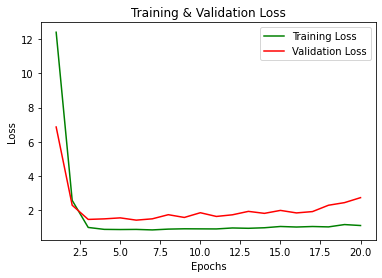

In [24]:
loss_train = models.history['loss']
loss_dev = models.history['val_loss']
epochs = range(1,EPOCHS+1)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_dev, 'r', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

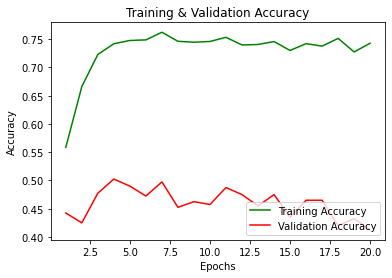

In [25]:
accuracy_train = models.history['accuracy']
accuracy_dev = models.history['val_accuracy']
epochs = range(1,EPOCHS+1)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_dev, 'r', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.show()

In [90]:
preds = model.evaluate(X_test,Y_test,batch_size=32,verbose=1,sample_weight = None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

400/400 [==============================] - 18s 44ms/step

Loss = 2.533152265548706
Test Accuracy = 0.42500001192092896


## Upload your own photo to play with the model

It's Jisoo!


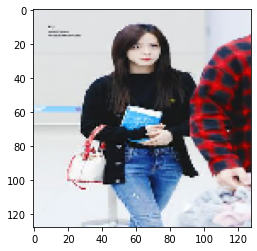

In [91]:
# upload an image
img_path = 'images/jisoo1.jpg'

img = image.load_img(img_path, target_size=(128, 128))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

result_list = model.predict(x)[0].tolist()

if result_list.index(max(result_list)) == 0:
    print(IDENTIFIER[0])
elif result_list.index(max(result_list)) == 1:
    print(IDENTIFIER[1])
elif result_list.index(max(result_list)) == 2:
    print(IDENTIFIER[2])
else:
    print(IDENTIFIER[3])

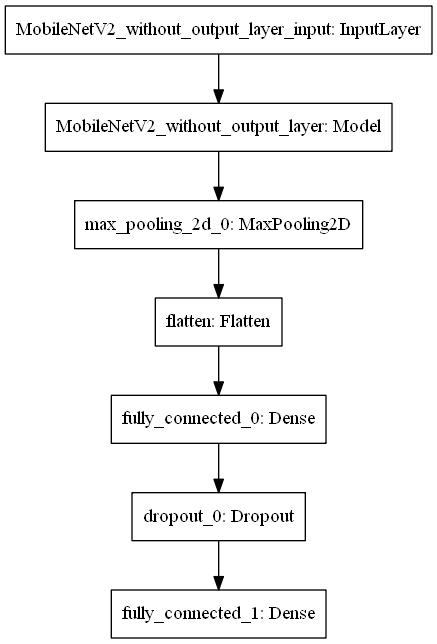

In [92]:
plot_model(model, to_file='model.jpg')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))